## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.integrate import odeint

from const import *
import ldf
import plotting
import method
import importlib

importlib.reload(plotting)
importlib.reload(ldf)
importlib.reload(method)

<module 'method' from 'c:\\Users\\GUNU\\Desktop\\negative-ion\\method.py'>

./211221(SF6)/SF6/Radial Scan_15sccm/0.ldf
no eedf datas


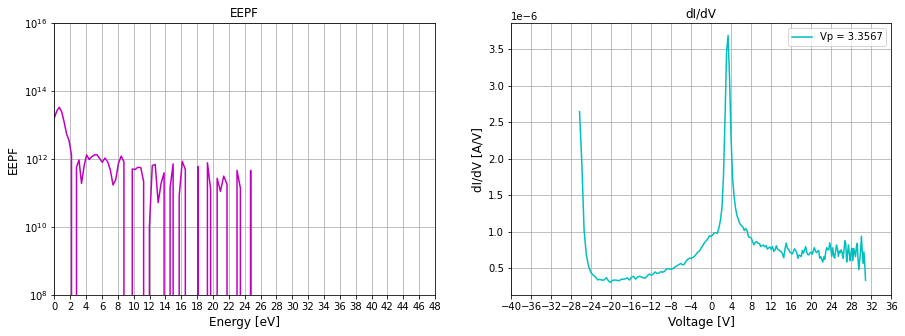

Enter limited energy
ne: 3.389e+13 [m-3]	 Te: 0.951 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4928	 gamma: 9.5098	 sol_number: 1
a_0: 4988.5609	 a_s: 3188.6554	 gamma: 9.5098	 sol_number: 1
a_0: 2015.5893	 a_s: 1288.1128	 gamma: 9.5098	 sol_number: 1
a_0: 1145.9775	 a_s: 732.1928	 gamma: 9.5098	 sol_number: 1
a_0: 863.8766	 a_s: 551.8531	 gamma: 9.5098	 sol_number: 1
a_0: 749.9731	 a_s: 479.0376	 gamma: 9.5098	 sol_number: 1
a_0: 698.7605	 a_s: 446.2987	 gamma: 9.5098	 sol_number: 1
a_0: 674.4744	 a_s: 430.7733	 gamma: 9.5098	 sol_number: 1
a_0: 662.6481	 a_s: 423.213	 gamma: 9.5098	 sol_number: 1
a_0: 656.8125	 a_s: 419.4825	 gamma: 9.5098	 sol_number: 1
a_0: 653.9139	 a_s: 417.6295	 gamma: 9.5098	 sol_number: 1
a_0: 652.4694	 a_s: 416.706	 gamma: 9.5098	 sol_number: 1
a_0: 651.7483	 a_s: 416.2451	 gamma: 9.5098	 sol_number: 1
Vp: 3.35671, Vsat: 26.3163, Isat: 1.92473e-05


./211221(SF6)/SF6/Radial Scan_15sccm/7.ldf
no eedf datas


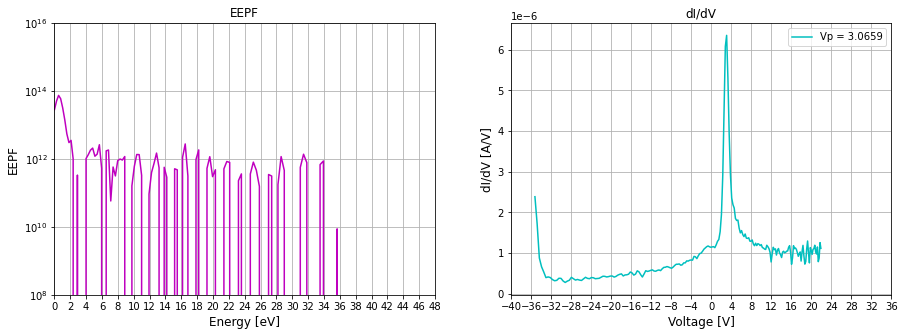

Enter limited energy
ne: 6.553e+13 [m-3]	 Te: 0.840 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.5253	 gamma: 8.3990	 sol_number: 1
a_0: 3666.0508	 a_s: 2359.5748	 gamma: 8.3990	 sol_number: 1
a_0: 1354.9941	 a_s: 871.8682	 gamma: 8.3990	 sol_number: 1
a_0: 739.5454	 a_s: 475.6827	 gamma: 8.3990	 sol_number: 1
a_0: 546.1234	 a_s: 351.1703	 gamma: 8.3990	 sol_number: 1
a_0: 469.2200	 a_s: 301.6649	 gamma: 8.3990	 sol_number: 1
a_0: 434.9042	 a_s: 279.5746	 gamma: 8.3990	 sol_number: 1
a_0: 418.6919	 a_s: 269.1383	 gamma: 8.3990	 sol_number: 1
a_0: 410.8120	 a_s: 264.0656	 gamma: 8.3990	 sol_number: 1
a_0: 406.9273	 a_s: 261.5649	 gamma: 8.3990	 sol_number: 1
a_0: 404.9986	 a_s: 260.3234	 gamma: 8.3990	 sol_number: 1
a_0: 404.0377	 a_s: 259.7048	 gamma: 8.3990	 sol_number: 1
a_0: 403.5580	 a_s: 259.396	 gamma: 8.3990	 sol_number: 1
Vp: 3.06594, Vsat: 35.2269, Isat: 2.71354e-05


./211221(SF6)/SF6/Radial Scan_15sccm/14.ldf
no eedf datas


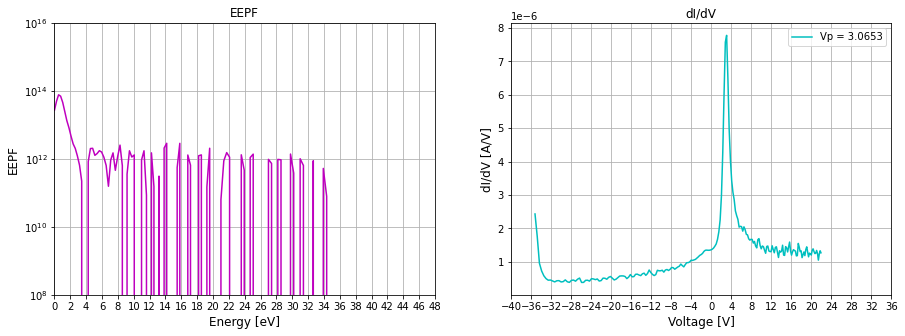

Enter limited energy
ne: 7.824e+13 [m-3]	 Te: 0.961 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4903	 gamma: 9.6065	 sol_number: 1
a_0: 3640.4408	 a_s: 2325.605	 gamma: 9.6065	 sol_number: 1
a_0: 1484.4277	 a_s: 948.052	 gamma: 9.6065	 sol_number: 1
a_0: 847.4908	 a_s: 541.0904	 gamma: 9.6065	 sol_number: 1
a_0: 640.1381	 a_s: 408.6054	 gamma: 9.6065	 sol_number: 1
a_0: 556.2686	 a_s: 355.0182	 gamma: 9.6065	 sol_number: 1
a_0: 518.5263	 a_s: 330.9033	 gamma: 9.6065	 sol_number: 1
a_0: 500.6202	 a_s: 319.4625	 gamma: 9.6065	 sol_number: 1
a_0: 491.8987	 a_s: 313.8901	 gamma: 9.6065	 sol_number: 1
a_0: 487.5947	 a_s: 311.1401	 gamma: 9.6065	 sol_number: 1
a_0: 485.4567	 a_s: 309.774	 gamma: 9.6065	 sol_number: 1
a_0: 484.3912	 a_s: 309.0932	 gamma: 9.6065	 sol_number: 1
a_0: 483.8594	 a_s: 308.7534	 gamma: 9.6065	 sol_number: 1
Vp: 3.06526, Vsat: 35.2108, Isat: 3.24462e-05


./211221(SF6)/SF6/Radial Scan_15sccm/21.ldf
no eedf datas


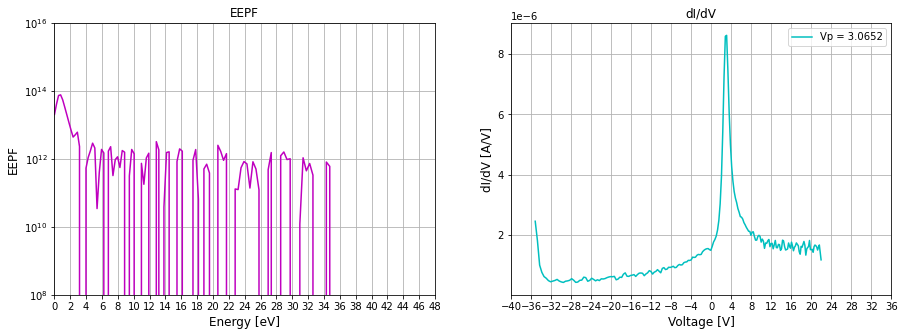

Enter limited energy
ne: 8.251e+13 [m-3]	 Te: 1.063 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4662	 gamma: 10.6265	 sol_number: 1
a_0: 3970.5453	 a_s: 2523.8687	 gamma: 10.6265	 sol_number: 1
a_0: 1753.7485	 a_s: 1114.5374	 gamma: 10.6265	 sol_number: 1
a_0: 1039.1076	 a_s: 660.2035	 gamma: 10.6265	 sol_number: 1
a_0: 799.6411	 a_s: 507.9624	 gamma: 10.6265	 sol_number: 1
a_0: 701.4077	 a_s: 445.5104	 gamma: 10.6265	 sol_number: 1
a_0: 656.8931	 a_s: 417.2102	 gamma: 10.6265	 sol_number: 1
a_0: 635.7010	 a_s: 403.7373	 gamma: 10.6265	 sol_number: 1
a_0: 625.3613	 a_s: 397.1638	 gamma: 10.6265	 sol_number: 1
a_0: 620.2543	 a_s: 393.917	 gamma: 10.6265	 sol_number: 1
a_0: 617.7164	 a_s: 392.3035	 gamma: 10.6265	 sol_number: 1
a_0: 616.4513	 a_s: 391.4992	 gamma: 10.6265	 sol_number: 1
a_0: 615.8197	 a_s: 391.0977	 gamma: 10.6265	 sol_number: 1
Vp: 3.06519, Vsat: 35.1699, Isat: 3.75418e-05


./211221(SF6)/SF6/Radial Scan_15sccm/28.ldf
no eedf datas


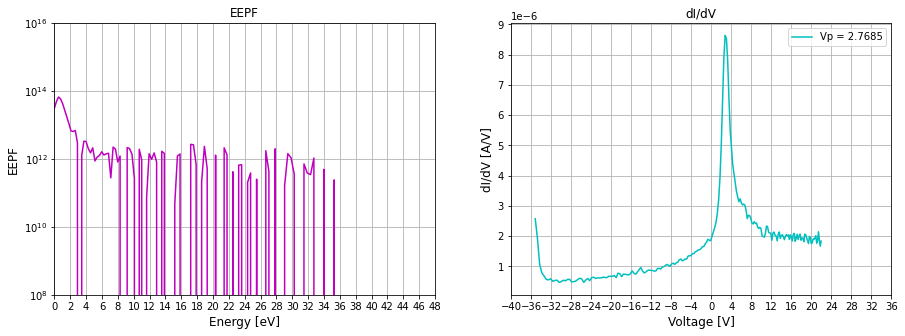

Enter limited energy
ne: 7.340e+13 [m-3]	 Te: 0.952 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4925	 gamma: 9.5192	 sol_number: 1
a_0: 5037.5454	 a_s: 3219.8024	 gamma: 9.5192	 sol_number: 1
a_0: 2325.1014	 a_s: 1485.8984	 gamma: 9.5192	 sol_number: 1
a_0: 1413.0183	 a_s: 902.858	 gamma: 9.5192	 sol_number: 1
a_0: 1101.3488	 a_s: 703.6262	 gamma: 9.5192	 sol_number: 1
a_0: 972.2679	 a_s: 621.1124	 gamma: 9.5192	 sol_number: 1
a_0: 913.4982	 a_s: 583.5445	 gamma: 9.5192	 sol_number: 1
a_0: 885.4542	 a_s: 565.6176	 gamma: 9.5192	 sol_number: 1
a_0: 871.7554	 a_s: 556.8608	 gamma: 9.5192	 sol_number: 1
a_0: 864.9853	 a_s: 552.5331	 gamma: 9.5192	 sol_number: 1
a_0: 861.6199	 a_s: 550.3818	 gamma: 9.5192	 sol_number: 1
a_0: 859.9421	 a_s: 549.3093	 gamma: 9.5192	 sol_number: 1
Vp: 2.76851, Vsat: 35.168, Isat: 4.20929e-05


./211221(SF6)/SF6/Radial Scan_15sccm/35.ldf


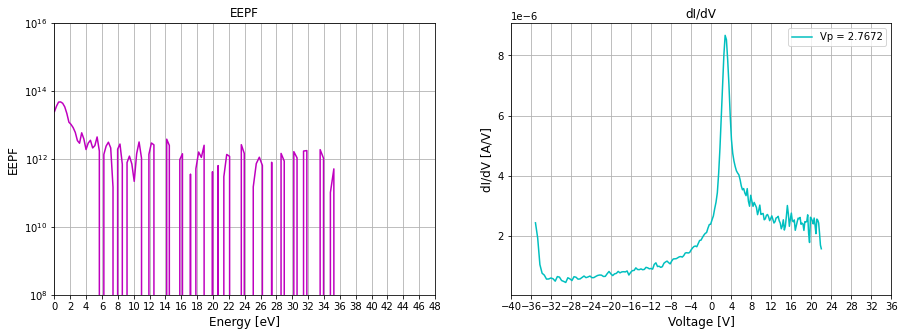

Enter limited energy
ne: 6.485e+13 [m-3]	 Te: 1.079 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4628	 gamma: 10.7878	 sol_number: 1
a_0: 6142.4045	 a_s: 3901.8837	 gamma: 10.7878	 sol_number: 1
a_0: 2978.5012	 a_s: 1891.8426	 gamma: 10.7878	 sol_number: 1
a_0: 1848.6622	 a_s: 1174.0512	 gamma: 10.7878	 sol_number: 1
a_0: 1456.2365	 a_s: 924.7415	 gamma: 10.7878	 sol_number: 1
a_0: 1292.4078	 a_s: 820.6604	 gamma: 10.7878	 sol_number: 1
a_0: 1217.5232	 a_s: 773.0859	 gamma: 10.7878	 sol_number: 1
a_0: 1181.7194	 a_s: 750.3396	 gamma: 10.7878	 sol_number: 1
a_0: 1164.2130	 a_s: 739.2177	 gamma: 10.7878	 sol_number: 1
a_0: 1155.5570	 a_s: 733.7185	 gamma: 10.7878	 sol_number: 1
a_0: 1151.2531	 a_s: 730.9842	 gamma: 10.7878	 sol_number: 1
a_0: 1149.1071	 a_s: 729.6209	 gamma: 10.7878	 sol_number: 1
Vp: 2.76716, Vsat: 35.1215, Isat: 4.56797e-05


./211221(SF6)/SF6/Radial Scan_15sccm/42.ldf


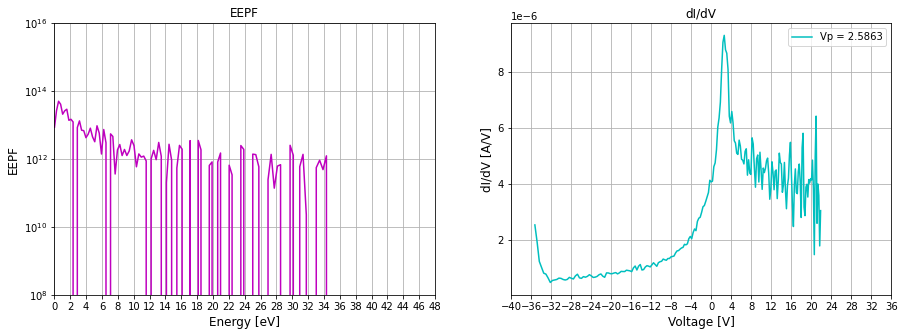

Enter limited energy
ne: 5.347e+13 [m-3]	 Te: 1.111 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4563	 gamma: 11.1076	 sol_number: 1
a_0: 7932.6105	 a_s: 5032.4864	 gamma: 11.1076	 sol_number: 1
a_0: 3951.6176	 a_s: 2506.7175	 gamma: 11.1076	 sol_number: 1
a_0: 2484.0031	 a_s: 1575.5792	 gamma: 11.1076	 sol_number: 1
a_0: 1969.2495	 a_s: 1248.9901	 gamma: 11.1076	 sol_number: 1
a_0: 1753.3203	 a_s: 1111.9923	 gamma: 11.1076	 sol_number: 1
a_0: 1654.3873	 a_s: 1049.2236	 gamma: 11.1076	 sol_number: 1
a_0: 1607.0298	 a_s: 1019.1773	 gamma: 11.1076	 sol_number: 1
a_0: 1583.8608	 a_s: 1004.4775	 gamma: 11.1076	 sol_number: 1
a_0: 1572.4015	 a_s: 997.2071	 gamma: 11.1076	 sol_number: 1
a_0: 1566.7029	 a_s: 993.5916	 gamma: 11.1076	 sol_number: 1
a_0: 1563.8613	 a_s: 991.7887	 gamma: 11.1076	 sol_number: 1
Vp: 2.58629, Vsat: 35.2402, Isat: 4.87129e-05




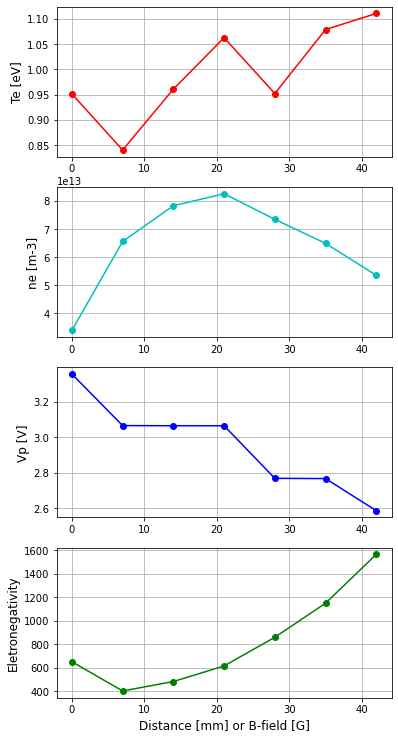

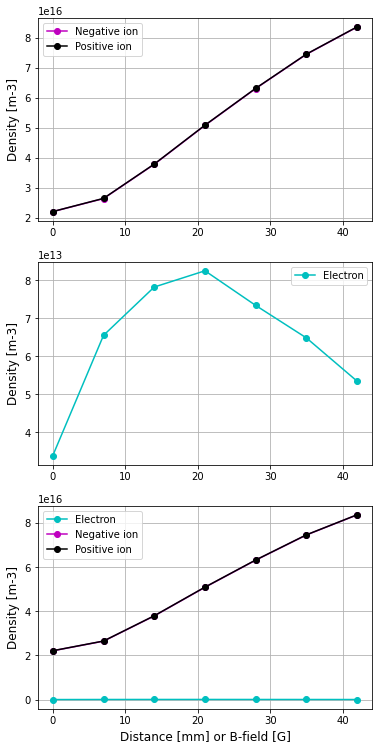

In [2]:
data = []

#workDir = './211216(SF6)/bias (float) 0mm B-field/'
workDir = './211221(SF6)/SF6/Radial Scan_15sccm/'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)

    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
    x = float(file.split('/')[-1][:-4])

    # Calculation x, Vsat, Isat, Vp, eepf, eedf from IV curve
    processor = ldf.processor(IV)
    Vsat, Isat = processor.cal_sat()
    Vp = processor.cal_Vp()
    energy, eepf, eedf = processor.cal_eepf()

    # Plot EEPF and dIdV to determine energy range 
    plotting.plot_check(energy, eepf, processor.V, processor.dIdV, Vp)

    # Enter energy range for EEDF integration to get ne & Te
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)

    # Calculation ne & Te from EEDF
    ne = processor.cal_ne(V_lim)
    Te = processor.cal_Te(ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    
    # Start Iterative method
    exp = method.iterative(ne,Te,Vsat,Isat,Vp)
    alpha = exp.iteration()
    nm = ne*alpha
    print("Vp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    
    data.append((Vp, alpha, Te, x, ne, nm))

df = pd.DataFrame(data, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])

plotting.plot_default(df['x'], df['Te'], df['Vp'], df['alpha'], df['ne'])

plotting.plot_density(df['x'], df['ne'], df['nm'])

The algorithm converged to the desired accuracy.


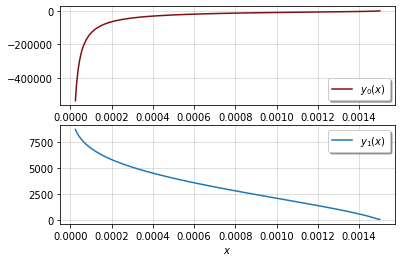

In [74]:
from scipy.integrate import solve_bvp
rp= 25e-6
J = 10
V = 50
uB = 100
R= 50e-5
def fun(r, y, r_sh):
    return np.vstack((r_sh*J/(r*epsilon_0*y[1])-y[0]/r, e*y[0]/(Mp*y[1])))

def bc(ya,yb,p):
    return np.array([yb[0],ya[1]-np.sqrt(2*e*V/Mp),yb[1]-uB])
# a=시작
# b=끝
# 0=E
# 1=u
n = 20
r = np.linspace(rp, 3*R, n)
y = np.array([np.linspace(V, 0, n)/(R-rp), np.linspace(np.sqrt(2*e*V/Mp), uB, n)])

sol = solve_bvp(fun, bc, r, y,p=(10*rp,))

if sol.status != 0:
    print("WARNING: sol.status is %d" % sol.status)
print(sol.message)

plt.subplot(2, 1, 1)
plt.plot(sol.x, sol.y[0], color='#801010', label='$y_0(x)$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.subplot(2, 1, 2)
plt.plot(sol.x, sol.y[1], '-', color='C0', label='$y_1(x)$')
plt.xlabel('$x$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()